In [1]:
import xarray as xr
import dask
from getpass import getuser
from pathlib import Path

import spot_the_blOb as blob
import spot_the_blOb.helper as hpc

In [2]:
# Start Dask Cluster
client = hpc.StartLocalCluster(n_workers=8, n_threads=2)

Memory per Worker: 62.96 GB


/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42005 instead
  warnings.warn(


Hostname is  l40031
Forward Port = l40031:42005
Dashboard Link: localhost:42005/status


In [3]:
# Load Pre-processed Data (cf. `01_preprocess_extremes.ipynb`)

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_binary.zarr'
chunk_size = {'time': 25, 'lat': -1, 'lon': -1}
ds = xr.open_zarr(str(file_name), chunks=chunk_size)

In [4]:
# Extract Binary Features and Modify Mask

extreme_bin = ds.extreme_events.isel(time=slice(100,102))
mask = ds.mask.where((ds.lat<85) & (ds.lat>-90), other=False)

In [5]:
drop_area_quartile = 0.5
filling_radius = 8
allow_merging = True
nn_partitioning = True

In [6]:
tracker = blob.Spotter(extreme_bin, mask, R_fill=filling_radius, area_filter_quartile=drop_area_quartile, 
                       allow_merging=allow_merging, nn_partitioning=nn_partitioning)

In [7]:
# extreme_bin_filled = tracker.fill_holes()

In [8]:
import xarray as xr
import numpy as np
from dask_image.ndmeasure import label
from skimage.measure import regionprops_table
from dask_image.ndmorph import binary_closing, binary_opening
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from dask import persist
from dask.base import is_dask_collection
from numba import jit, prange
import warnings
import matplotlib.pyplot as plt

import scipy.ndimage

In [9]:
# Generate Structuring Element
y, x = np.ogrid[-tracker.R_fill:tracker.R_fill+1, -tracker.R_fill:tracker.R_fill+1]
r = x**2 + y**2
se_kernel = r < (tracker.R_fill**2)+1

In [10]:
# Pad the binary data
diameter = 2 * tracker.R_fill
binary_data_padded = tracker.data_bin.pad({tracker.ydim: diameter, tracker.xdim: diameter, }, mode='wrap')

In [11]:

# # Apply binary closing and opening
# binary_data_closed = binary_closing(binary_data_padded.data, structure=se_kernel[np.newaxis, :, :])  # N.B.: Need to extract dask.array.Array from xarray.DataArray
# binary_data_opened = binary_opening(binary_data_closed, structure=se_kernel[np.newaxis, :, :])

# # Convert back to xarray.DataArray
# binary_data_opened = xr.DataArray(binary_data_opened, coords=binary_data_padded.coords, dims=binary_data_padded.dims)
# data_bin_filled    = binary_data_opened.isel({tracker.ydim: slice(diameter, -diameter), tracker.xdim: slice(diameter, -diameter)})

# # Mask out edge features arising from Morphological Operations
# data_bin_filled_mask = data_bin_filled.where(tracker.mask, drop=False, other=False)


In [12]:
## Revert to scipy implementation...

def binary_open_close(bitmap_binary):
    bitmap_binary_padded = np.pad(bitmap_binary,
                                    ((diameter, diameter), (diameter, diameter)),
                                    mode='wrap')
    s1 = scipy.ndimage.binary_closing(bitmap_binary_padded, se_kernel, iterations=1)
    s2 = scipy.ndimage.binary_opening(s1, se_kernel, iterations=1)
    unpadded= s2[diameter:-diameter, diameter:-diameter]
    return unpadded

data_bin_filled_mask = xr.apply_ufunc(binary_open_close, tracker.data_bin,
                            input_core_dims=[[tracker.ydim, tracker.xdim]],
                            output_core_dims=[[tracker.ydim, tracker.xdim]],
                            output_dtypes=[tracker.data_bin.dtype],
                            vectorize=True,
                            dask='parallelized')

In [13]:
extreme_bin_filled = data_bin_filled_mask

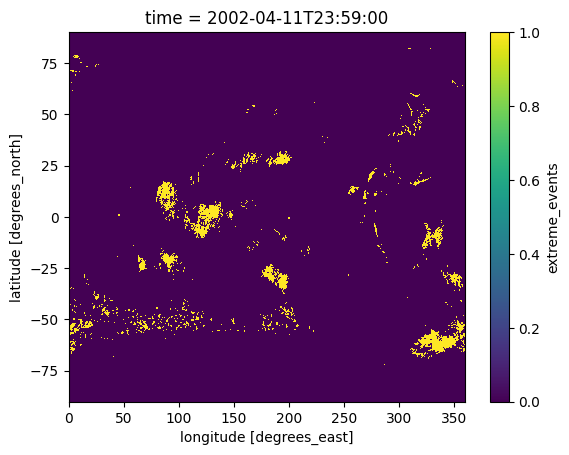

In [14]:
tracker.data_bin.isel(time=0).plot()

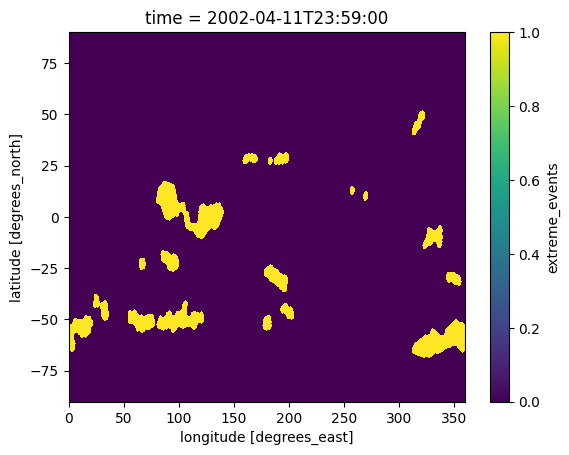

In [15]:
extreme_bin_filled.isel(time=0).plot()

(-10.0, 10.0)

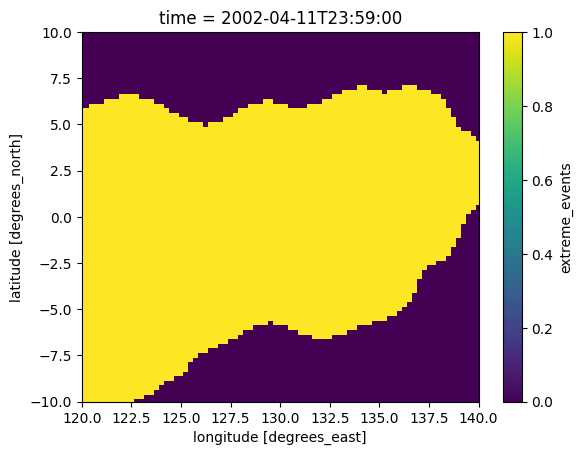

In [16]:
extreme_bin_filled.isel(time=0).plot()
# zoom in on lon = 125 lat = 0
plt.xlim(120, 140)
plt.ylim(-10, 10)